### Preducting Insurance Costs

This [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle contains information on individual medical insurance bills. 
Each bill is associated with some demographic and personal characteristics of the person who received it.
For our regression problem, we're interested in how these different characteristics relate to **total medical cost.**

**Goal:** Construct a predictive model for total medical cost.

**Purpose:** Predicting medical costs is an important task because it allows hopsitals to predict revenue and plan necessary procedures needed by its patient population.

In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [63]:
# Load in the insurance dataset
insurance = pd.read_csv('insurance.csv')

## Explore the Dataset

In [64]:
#columns in the dataset
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

The `charges` column is our outcome, while everything else are the potential predictors to use in the model

array([[<Axes: title={'center': 'charges'}>]], dtype=object)

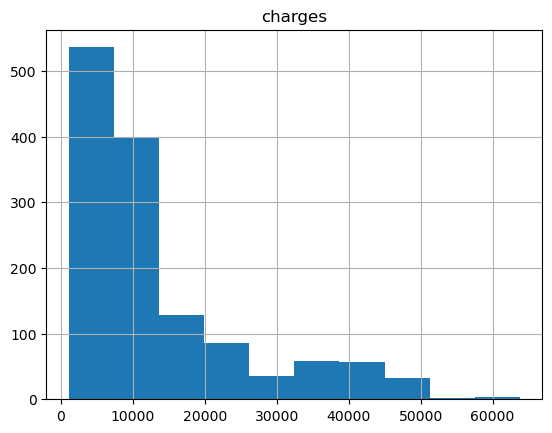

In [65]:
insurance.hist('charges')

The `charges` column is highly skewed to the right. Extremely costly insurance charges are less common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be wirth it to *log-transform* the outcome.

array([[<Axes: title={'center': 'log_charges'}>]], dtype=object)

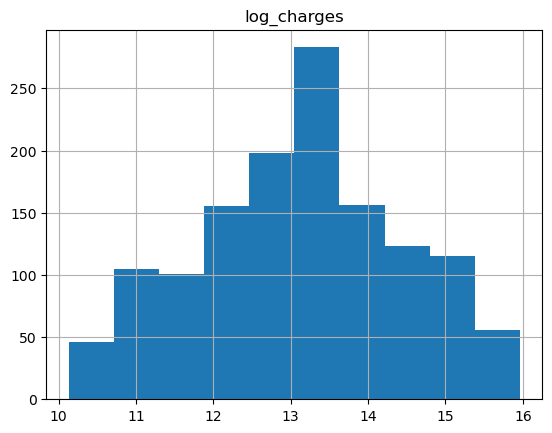

In [66]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance.hist('log_charges')

The log-transformed `charges` values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

In [67]:
#Check the correlation between the continuous columns in the insurance data
insurance.select_dtypes(include='number').corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


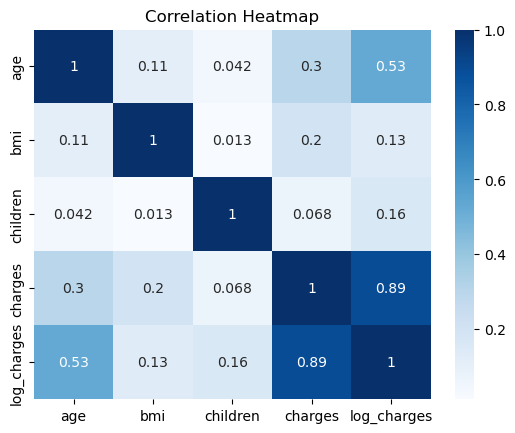

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns before computing correlation
numeric_data = insurance.select_dtypes(include='number')

# Create the heatmap
sns.heatmap(numeric_data.corr(), cmap='Blues', annot=True)

plt.title('Correlation Heatmap')
plt.show()



### Comments on correlation
`age` has a 30% correlation with `charges`, `bmi` has a 19.8% correlation, and number of children has a 6.7% correlation.

<Axes: title={'center': 'log_charges'}, xlabel='sex'>

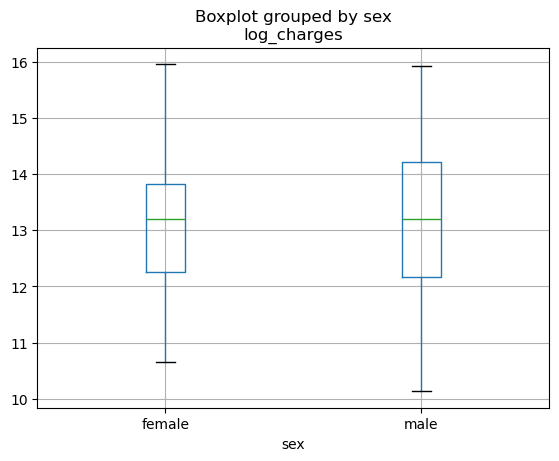

In [69]:
insurance.boxplot(column = ["log_charges"], by = "sex")

<Axes: title={'center': 'log_charges'}, xlabel='smoker'>

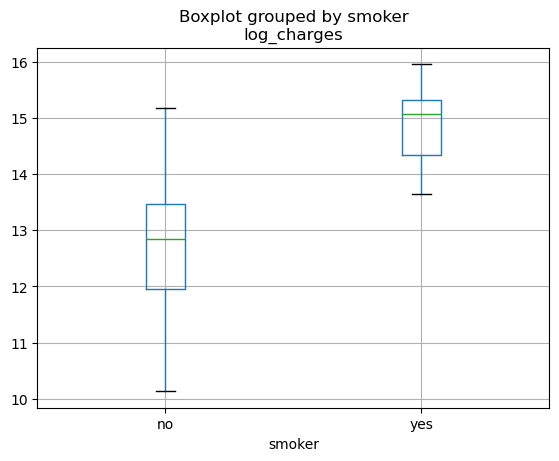

In [70]:
insurance.boxplot(column = ["log_charges"], by = "smoker")

<Axes: title={'center': 'log_charges'}, xlabel='region'>

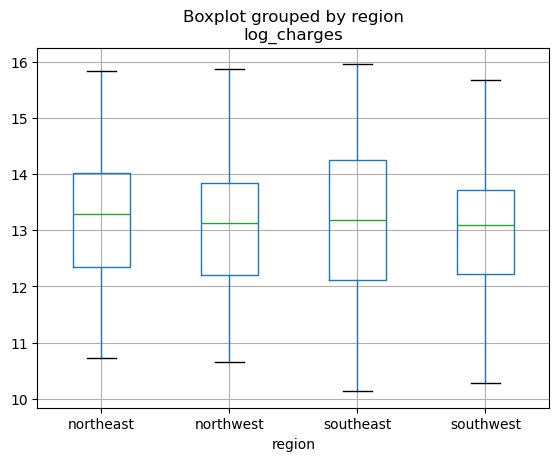

In [71]:
insurance.boxplot(column = ["log_charges"], by = "region")

### Comments on Plots
Males seem to have a wider distribution of charges compared to women.
Smokers have much higher costs than non-smokers.
There doesn't seem to be many appreciable differences between regions.

### Dividing the data
Based on the univariate relationships shown above, `age`, `bmi`, `smoker` are positively associated with higher `charges`. We'll include these predictors in our final model.

In [72]:
# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 1)

### Build the model

In [73]:
# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [74]:
# Get predicted values by model
y_pred = insurance_model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.4546665339270644

In [75]:
# MSE on the original scale for the insurance charges https://numpy.org/doc/stable/reference/generated/numpy.exp.html
# e^0.4566664 (E is eulers number)
np.exp(mean_squared_error(y_train, y_pred))


1.575647870310887

In [76]:
# Coefficient of determination
r2_score(y_train, y_pred)

0.7421118855283421

### **Comments**
The training MSE for the model is 0.454 and is 1.57 on the original scale. The $R^2$ indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

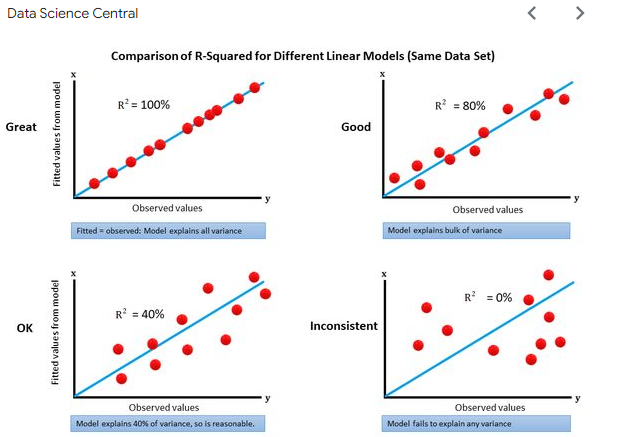

#### **Residual Diagnostics** 

<Axes: xlabel='fitted', ylabel='residuals'>

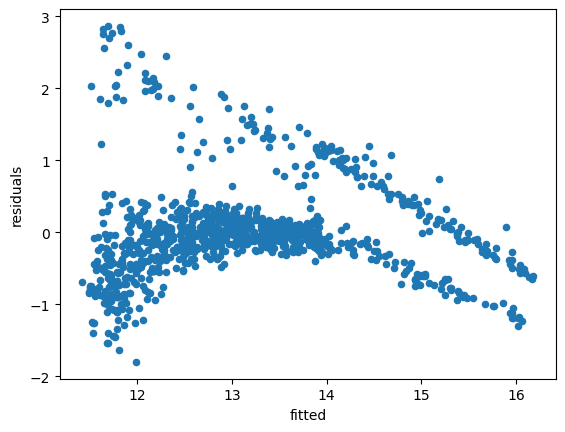

In [77]:
# Quick visual check of residuals
check = pd.DataFrame()
check['residuals'] = y_train - y_pred
check['fitted'] = y_pred

check.plot.scatter(x = 'fitted', y = 'residuals')


The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

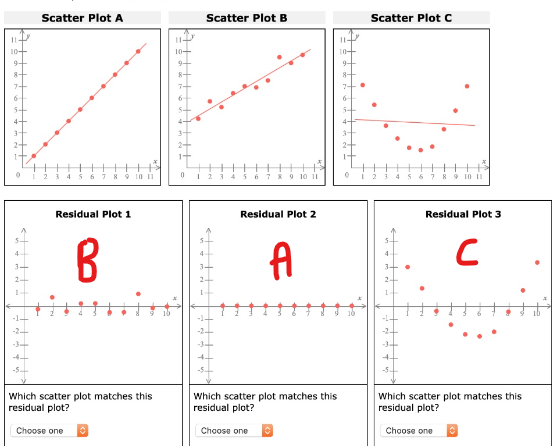

### Interpreting the Model

In [78]:
# Getting the non-intercept coefficients
print(X.columns)
print(insurance_model.coef_)

Index(['age', 'bmi', 'is_smoker'], dtype='object')
[0.04892865 0.01523672 2.23063344]


- A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
- A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.
- A smoker is asociated with a 2.23 increasei n the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.

Note: we are not concerned about it if these changes are *statistically significant*, so we don't know if these associates are truly non-zero. Our primary goal is prediction.

### **Final Model Evaluation**

In [79]:
#Getting MSE on test model
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4355350875308211

In [80]:
# Putting the outcome (in log-terms) back into the original scale
# Calculate the exponential of all elements in the input array. https://en.wikipedia.org/wiki/Exponential_function
#euler's number ^ x

np.exp(mean_squared_error(y_test, test_pred))

1.545789970635098

## **Drawing Conclusions**

The test MSE was about 0.435 while the training MSE was about 0.454. In this case, the two erros match up pretty well, so we can conclude the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. There the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.